# Perform single-cell quality control

In this notebook, we perform single-cell quality control using coSMicQC. We use features from the AreaShape and Intensity modules to assess the quality of the segmented single-cells.

## Import modules

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from cytodataframe import CytoDataFrame
from cosmicqc import find_outliers

## Set paths and variables

In [2]:
# Directory with data
data_dir = pathlib.Path("./data/converted_profiles/")

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
    "Metadata_Cells_Location_Center_X",
    "Metadata_Cells_Location_Center_Y",
    "Image_FileName_Hoechst",
    "Image_PathName_Hoechst",
    "Image_FileName_Actin",
    "Image_PathName_Actin",
]

## Load in plate to perform QC on

In [3]:
# Find the single converted parquet in the data directory and load it
files = list(data_dir.glob("*_converted.parquet"))

if len(files) == 0:
    raise FileNotFoundError(f"No *_converted.parquet files found in {data_dir}")
if len(files) > 1:
    print(
        f"More than one converted file found in {data_dir}, loading the first: {files[0].name}"
    )

file_path = files[0]
plate = file_path.stem.replace("_converted", "")

# Load in converted plate data
plate_df = pd.read_parquet(file_path)

# Add plate metadata column if absent
if "Image_Metadata_Plate" not in plate_df.columns:
    plate_df["Image_Metadata_Plate"] = plate

print(plate_df.shape)
plate_df.head()

(12158, 2476)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,222.515520,91.821668,227.192782,133.566315,13,8,CARD-CelIns-CX7_251023130003,f09,B02,1,...,6.456837,6.374919,0.507924,0.503667,0.532190,0.508049,1.454409,1.388667,1.442516,1.428607
1,364.706757,76.552703,364.512899,114.433453,8,18,CARD-CelIns-CX7_251023130003,f19,B02,1,...,126.824810,128.172289,253.705013,255.674477,241.869275,238.018235,192.838915,193.238477,179.877037,181.075333
2,666.890013,130.611252,672.886981,123.623609,6,27,CARD-CelIns-CX7_251023130003,f06,B03,1,...,6.010343,5.910654,1.187196,1.189512,1.345693,1.092350,1.067978,1.066763,1.049050,1.053286
3,123.713090,154.224505,134.946109,181.746611,8,36,CARD-CelIns-CX7_251023130003,f18,B03,1,...,26.468006,25.320270,2.922932,2.788681,2.784761,2.638553,1.242155,1.160329,1.294659,1.258544
4,80.011967,200.934181,144.184192,207.999922,11,37,CARD-CelIns-CX7_251023130003,f19,B03,1,...,21.551625,20.193449,2.876889,2.807296,3.005361,2.920501,4.535811,4.277873,4.300654,4.117515


In [4]:
# set compartment for segmentation mask
compartment = "Nuclei"

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    f"Metadata_{compartment}_Location_Center_X",
    f"Metadata_{compartment}_Location_Center_Y",
    "Image_FileName_Hoechst",
    "Image_FileName_Actin",
    "Image_PathName_Hoechst",
    "Image_PathName_Actin",
    f"{compartment}_AreaShape_BoundingBoxMaximum_X",
    f"{compartment}_AreaShape_BoundingBoxMaximum_Y",
    f"{compartment}_AreaShape_BoundingBoxMinimum_X",
    f"{compartment}_AreaShape_BoundingBoxMinimum_Y",
]

In [5]:
# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {}
for record in plate_df[
    [
        "Image_Metadata_Plate",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
    ]
].to_dict(orient="records"):
    site_raw = str(record["Image_Metadata_Site"])
    # extract digits from the site string (e.g., 'f09' -> '09')
    site_digits = re.sub(r"\D", "", site_raw)
    if site_digits == "":
        site_fmt = site_raw
    else:
        site_fmt = f"{int(site_digits):02d}"

    key = rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff"
    value = rf"{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}f{site_fmt}d\d+_illumcorrect\.tiff"
    outline_to_orig_mapping[key] = value
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('NucleiOutlines_CARD-CelIns-CX7_251023130003_B02_f09.tiff',
 'CARD-CelIns-CX7_251023130003_B02f09d\\d+_illumcorrect\\.tiff')

## Oversegmented nuclei with very high intensity (clusters)

Number of outliers: 263 (2.16%)
Outliers Range:
Nuclei_Intensity_MassDisplacement_Hoechst Min: 0.8053197667362303
Nuclei_Intensity_MassDisplacement_Hoechst Max: 8.171997483893872
Nuclei_AreaShape_Solidity Min: 0.7662740235585865
Nuclei_AreaShape_Solidity Max: 0.9673024523160763
(263, 3)


,9974,9693,2874,7053,1
Nuclei_Intensity_MassDisplacement_Hoechst,0.843746,1.892941,1.123702,0.991,2.265647
Nuclei_AreaShape_Solidity,0.952698,0.953729,0.964715,0.949814,0.87574
Image_FileName_Hoechst,,,,,

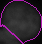
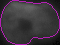
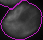
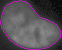
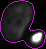

In [6]:
# find large nuclei clusters
feature_thresholds = {
    "Nuclei_Intensity_MassDisplacement_Hoechst": 1.0,
    "Nuclei_AreaShape_Solidity": -0.8,
}

oversegmented_nuclei_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
oversegmented_nuclei_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(oversegmented_nuclei_outliers),
    data_outline_context_dir="../2.extract_features/cp_output/CARD-CelIns-CX7_251023130003",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "outline_color": (180, 30, 180),  # magenta
        "brightness": 1,
    },
)[
    [
        "Nuclei_Intensity_MassDisplacement_Hoechst",
        "Nuclei_AreaShape_Solidity",
        "Image_FileName_Hoechst",
    ]
]


print(oversegmented_nuclei_outliers_cdf.shape)
# oversegmented_nuclei_outliers_cdf.sort_values(
#     by="Nuclei_Intensity_MassDisplacement_Hoechst", ascending=True
# ).head(5).T
oversegmented_nuclei_outliers_cdf.sample(n=5).T

Number of outliers: 299 (2.46%)
Outliers Range:
Nuclei_AreaShape_Solidity Min: 0.7662740235585865
Nuclei_AreaShape_Solidity Max: 0.9523809523809523
(299, 2)


,7295,8349,5588,6133,4584
Nuclei_AreaShape_Solidity,0.934906,0.912107,0.907634,0.948529,0.945545
Image_FileName_Hoechst,,,,,

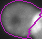
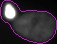
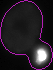
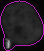
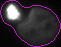

In [7]:
# find non-round nuclei (poorly segmented)
feature_thresholds = {
    "Nuclei_AreaShape_Solidity": -2.2,
}

poorly_segmented_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
poorly_segmented_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(poorly_segmented_outliers),
    data_outline_context_dir="../2.extract_features/cp_output/CARD-CelIns-CX7_251023130003",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "outline_color": (180, 30, 180),  # magenta
        "brightness": 1,
    },
)[
    [
        "Nuclei_AreaShape_Solidity",
        "Image_FileName_Hoechst",
    ]
]


print(poorly_segmented_outliers_cdf.shape)
# large_nuclei_high_int_outliers_cdf.sort_values(
#     by="Nuclei_Intensity_MassDisplacement_Hoechst", ascending=True
# ).head(5).T
poorly_segmented_outliers_cdf.sample(n=5).T

### Scatterplot of mass displacement to solidity

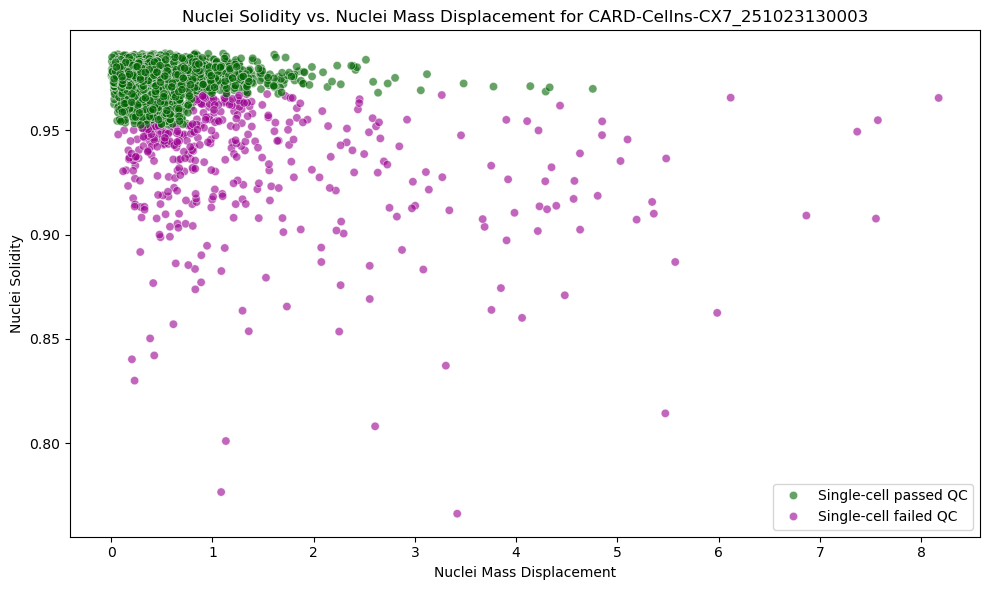

In [8]:
# Set the default value to 'inlier'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Mark outliers from both nuclei clusters and poorly segmented nuclei
combined_idx = pd.Index(oversegmented_nuclei_outliers.index).union(
    pd.Index(poorly_segmented_outliers.index)
)
plate_df.loc[plate_df.index.isin(combined_idx), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_df,
    x="Nuclei_Intensity_MassDisplacement_Hoechst",
    y="Nuclei_AreaShape_Solidity",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Single-cell failed QC": "#990090",
    },  # Specify colors
    alpha=0.6,
)

plt.title(f"Nuclei Solidity vs. Nuclei Mass Displacement for {plate}")
plt.xlabel("Nuclei Mass Displacement")
plt.ylabel("Nuclei Solidity")
plt.tight_layout()

# Show the legend
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0), prop={"size": 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_outliers.png"), dpi=500)

plt.show()

## Mis-segmented cells due to high confluence (segmentation for cells around the nuclei)

In [9]:
# set compartment for segmentation mask
compartment = "Cells"

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    f"Metadata_{compartment}_Location_Center_X",
    f"Metadata_{compartment}_Location_Center_Y",
    "Image_FileName_Hoechst",
    "Image_FileName_Actin",
    "Image_PathName_Hoechst",
    "Image_PathName_Actin",
    f"{compartment}_AreaShape_BoundingBoxMaximum_X",
    f"{compartment}_AreaShape_BoundingBoxMaximum_Y",
    f"{compartment}_AreaShape_BoundingBoxMinimum_X",
    f"{compartment}_AreaShape_BoundingBoxMinimum_Y",
]

In [10]:
# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {}
for record in plate_df[
    [
        "Image_Metadata_Plate",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
    ]
].to_dict(orient="records"):
    site_raw = str(record["Image_Metadata_Site"])
    # extract digits from the site string (e.g., 'f09' -> '09')
    site_digits = re.sub(r"\D", "", site_raw)
    if site_digits == "":
        site_fmt = site_raw
    else:
        site_fmt = f"{int(site_digits):02d}"

    key = rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff"
    value = rf"{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}f{site_fmt}d\d+_illumcorrect\.tiff"
    outline_to_orig_mapping[key] = value
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('CellsOutlines_CARD-CelIns-CX7_251023130003_B02_f09.tiff',
 'CARD-CelIns-CX7_251023130003_B02f09d\\d+_illumcorrect\\.tiff')

Number of outliers: 567 (4.66%)
Outliers Range:
Cells_AreaShape_Area Min: 733.0
Cells_AreaShape_Area Max: 7485.0
(567, 2)


,5495,11242,5188,281,10493
Cells_AreaShape_Area,6172.0,2095.0,2689.0,1472.0,5796.0
Image_FileName_Actin,,,,,

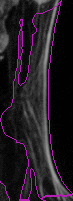
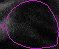
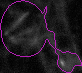
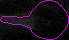
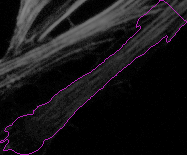

In [11]:
# find under-segmented cells (small cells)
feature_thresholds = {
    "Cells_AreaShape_Area": -1.5,
}

small_cells_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
small_cells_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(small_cells_outliers),
    data_outline_context_dir="../2.extract_features/cp_output/CARD-CelIns-CX7_251023130003",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "outline_color": (180, 30, 180),  # magenta
        "brightness": 1,
    },
)[
    [
        "Cells_AreaShape_Area",
        "Image_FileName_Actin",
    ]
]


print(small_cells_outliers_cdf.shape)
# large_nuclei_high_int_outliers_cdf.sort_values(
#     by="Nuclei_Intensity_MassDisplacement_Hoechst", ascending=True
# ).head(5).T
small_cells_outliers_cdf.sample(n=5).T

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


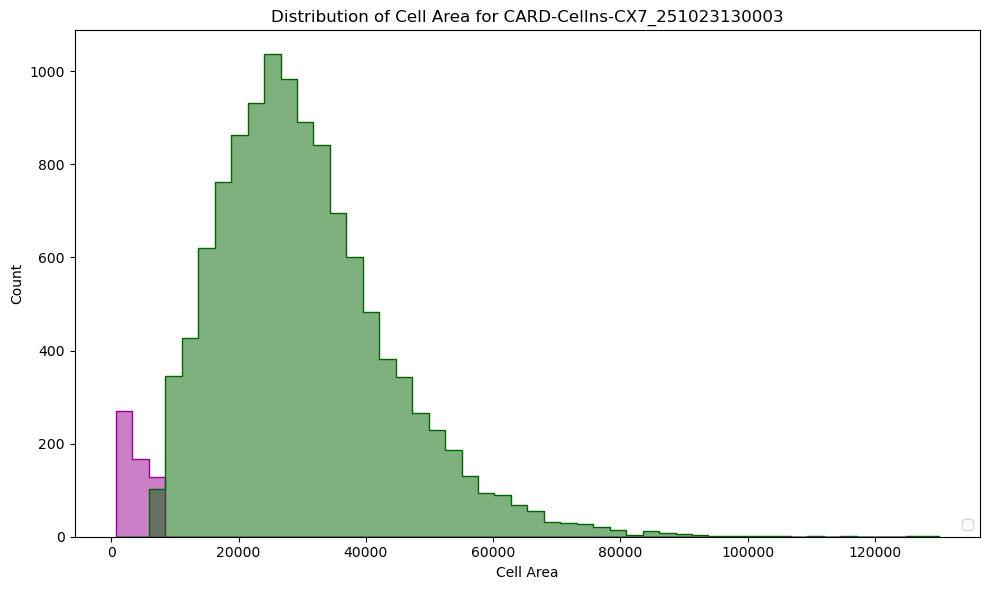

In [12]:
# Set the default value to 'inlier'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Mark outliers from under-segmented cells
combined_idx = pd.Index(small_cells_outliers.index)
plate_df.loc[plate_df.index.isin(combined_idx), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=plate_df,
    x="Cells_AreaShape_Area",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Single-cell failed QC": "#990090",
    },
    element="step",
    bins=50,
    alpha=0.5,
)

plt.title(f"Distribution of Cell Area for {plate}")
plt.xlabel("Cell Area")
plt.ylabel("Count")
plt.tight_layout()

# Show the legend
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0), prop={"size": 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_cells_outliers.png"), dpi=500)

plt.show()

## Detect blurry cells

Number of outliers: 481 (3.96%)
Outliers Range:
Nuclei_Texture_InfoMeas1_Hoechst_3_02_256 Min: -0.3856268896028014
Nuclei_Texture_InfoMeas1_Hoechst_3_02_256 Max: -0.216962671708293
Cells_Texture_InfoMeas1_Actin_3_02_256 Min: -0.5695632985730716
Cells_Texture_InfoMeas1_Actin_3_02_256 Max: -0.29084906839238794
(481, 5)


,9584,10462,5166,10707,2703
Image_Metadata_Well,B09,D09,E11,C05,D02
Image_Metadata_Site,f20,f01,f12,f19,f22
Nuclei_Texture_InfoMeas1_Hoechst_3_02_256,-0.310716,-0.266519,-0.305839,-0.29911,-0.226266
Cells_Texture_InfoMeas1_Actin_3_02_256,-0.426881,-0.397762,-0.492324,-0.342869,-0.317095
Image_FileName_Actin,,,,,

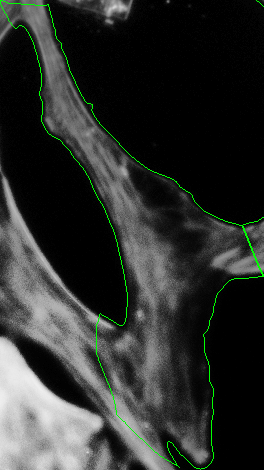
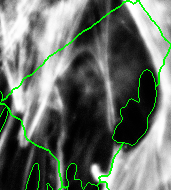
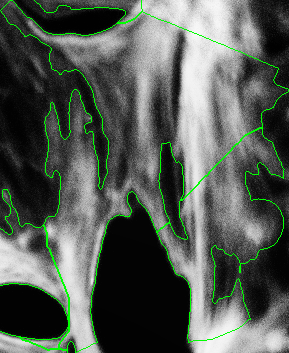
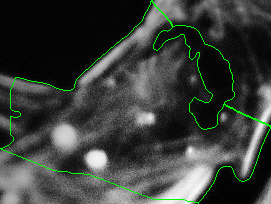
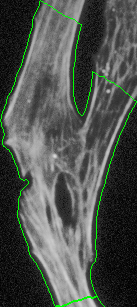

In [13]:
# find blurry cells
feature_thresholds = {
    "Nuclei_Texture_InfoMeas1_Hoechst_3_02_256": -1.5,
    "Cells_Texture_InfoMeas1_Actin_3_02_256": -1.0,
}

blurry_cells_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
blurry_cells_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(blurry_cells_outliers),
    data_outline_context_dir="../2.extract_features/cp_output/CARD-CelIns-CX7_251023130003",
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "brightness": 5,
    },
)[
    [
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Nuclei_Texture_InfoMeas1_Hoechst_3_02_256",
        "Cells_Texture_InfoMeas1_Actin_3_02_256",
        "Image_FileName_Actin",
    ]
]


print(blurry_cells_outliers_cdf.shape)
# blurry_cells_outliers_cdf.sort_values(
#     by="Nuclei_Texture_InfoMeas1_Hoechst_3_02_256", ascending=False
# ).head(10)
blurry_cells_outliers_cdf.sample(n=5).T

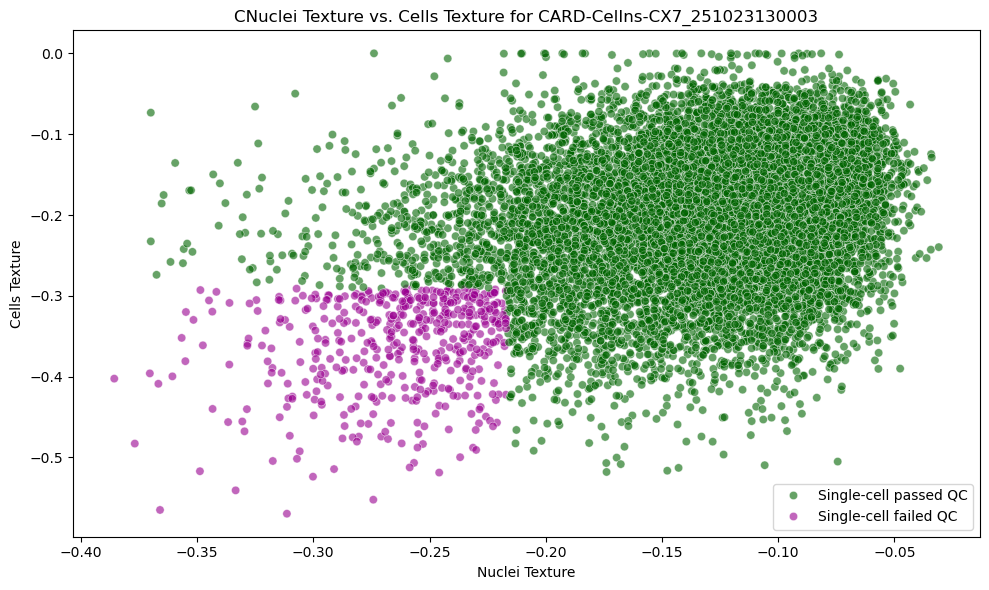

In [14]:
# Set the default value to 'inlier'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Mark outliers from under-segmented cells
combined_idx = pd.Index(blurry_cells_outliers.index)
plate_df.loc[plate_df.index.isin(combined_idx), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_df,
    x="Nuclei_Texture_InfoMeas1_Hoechst_3_02_256",
    y="Cells_Texture_InfoMeas1_Actin_3_02_256",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Single-cell failed QC": "#990090",
    },  # Specify colors
    alpha=0.6,
)

plt.title(f"CNuclei Texture vs. Cells Texture for {plate}")
plt.xlabel("Nuclei Texture")
plt.ylabel("Cells Texture")
plt.tight_layout()

# Show the legend
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0), prop={"size": 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_blurry_outliers.png"), dpi=500)

plt.show()

## Remove all outliers and save cleaned data frame

In [15]:
# Collect indices from all known outlier dataframes in the notebook
outlier_names = [
    "large_nuclei_high_int_outliers",
    "oversegmented_nuclei_outliers",
    "poorly_segmented_outliers",
    "small_cells_outliers",
    "blurry_cells_outliers",
]

outlier_frames = []
for name in outlier_names:
    try:
        obj = eval(name)
    except NameError:
        continue

    # If already a DataFrame or CytoDataFrame-like, take it; otherwise try to coerce
    if isinstance(obj, pd.DataFrame):
        outlier_frames.append(obj)
    else:
        try:
            outlier_frames.append(pd.DataFrame(obj))
        except Exception:
            # skip objects that cannot be converted
            continue

if outlier_frames:
    outlier_indices = pd.Index(pd.concat(outlier_frames).index.unique())
else:
    outlier_indices = pd.Index([])

print(
    f"Found {len(outlier_indices)} unique outlier indices from: "
    + ", ".join([n for n in outlier_names if n in globals()])
)

# Remove rows with outlier indices from plate_4_df
plate_df_cleaned = plate_df.drop(outlier_indices)

# Save cleaned data for this plate
plate_name = plate_df["Image_Metadata_Plate"].iloc[0]
plate_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_name}_cleaned.parquet")

# Verify the result
print(plate_df_cleaned.shape)
plate_df_cleaned.head()

Found 1309 unique outlier indices from: oversegmented_nuclei_outliers, poorly_segmented_outliers, small_cells_outliers, blurry_cells_outliers
(10849, 2477)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256,Outlier_Status
0,222.515520,91.821668,227.192782,133.566315,13,8,CARD-CelIns-CX7_251023130003,f09,B02,1,...,6.374919,0.507924,0.503667,0.532190,0.508049,1.454409,1.388667,1.442516,1.428607,Single-cell passed QC
2,666.890013,130.611252,672.886981,123.623609,6,27,CARD-CelIns-CX7_251023130003,f06,B03,1,...,5.910654,1.187196,1.189512,1.345693,1.092350,1.067978,1.066763,1.049050,1.053286,Single-cell passed QC
3,123.713090,154.224505,134.946109,181.746611,8,36,CARD-CelIns-CX7_251023130003,f18,B03,1,...,25.320270,2.922932,2.788681,2.784761,2.638553,1.242155,1.160329,1.294659,1.258544,Single-cell passed QC
4,80.011967,200.934181,144.184192,207.999922,11,37,CARD-CelIns-CX7_251023130003,f19,B03,1,...,20.193449,2.876889,2.807296,3.005361,2.920501,4.535811,4.277873,4.300654,4.117515,Single-cell passed QC
6,770.502356,85.859246,839.929902,80.763261,15,79,CARD-CelIns-CX7_251023130003,f22,B05,1,...,6.333577,2.657161,2.685945,2.575967,2.560161,1.787297,1.747746,1.686217,1.598789,Single-cell passed QC


In [16]:
# Compute overall and per-well QC failure rates using outlier_indices
if "plate_df" not in globals():
    raise NameError(
        "plate_df not found in the notebook namespace. Run the cell that loads the plate first."
    )
if "outlier_indices" not in globals():
    raise NameError(
        "outlier_indices not found. Run the cell that collects outlier indices (cell 22)."
    )

df_all = plate_df
total_cells = len(df_all)

# Ensure outlier_indices is an Index and restrict to indices present in plate_df
out_idx = pd.Index(outlier_indices)
out_idx_in_df = df_all.index.intersection(out_idx)

n_failed = int(len(out_idx_in_df))
pct_failed = n_failed / total_cells * 100 if total_cells else 0.0

print(f"Total cells: {total_cells}")
print(f"Outlier indices provided: {len(out_idx)}")
print(f"Outlier indices present in plate_df: {n_failed} ({pct_failed:.2f}%)")

# Per-well failure percentages using outlier indices
well_counts = df_all.groupby("Image_Metadata_Well").size().rename("total")
well_failed = (
    df_all.loc[df_all.index.isin(out_idx_in_df)]
    .groupby("Image_Metadata_Well")
    .size()
    .rename("failed")
)

well_stats = (
    pd.concat([well_counts, well_failed], axis=1)
    .fillna(0)
    .astype({"total": int, "failed": int})
)
well_stats["failed_pct"] = well_stats["failed"] / well_stats["total"] * 100

# Sort and show top wells
well_stats = well_stats.sort_values("failed_pct", ascending=False)
top_n = globals().get("top_n", 10)
print(f"\nTop {top_n} wells by % failed:")
print(well_stats.head(top_n).to_string())

# Save summary for later use
plate_qc_summary = {
    "total_cells": total_cells,
    "failed_cells": n_failed,
    "failed_pct": pct_failed,
    "outlier_indices_total": len(out_idx),
    "outlier_indices_used": len(out_idx_in_df),
    "well_stats": well_stats,
}

Total cells: 12158
Outlier indices provided: 1309
Outlier indices present in plate_df: 1309 (10.77%)

Top 10 wells by % failed:
                     total  failed  failed_pct
Image_Metadata_Well                           
F09                    171      34   19.883041
E05                    251      46   18.326693
B08                     47       8   17.021277
G06                    176      29   16.477273
C03                    207      34   16.425121
C10                    197      29   14.720812
G07                     96      14   14.583333
B07                    317      46   14.511041
F10                    378      53   14.021164
B05                    145      20   13.793103
